BSC model
=========

We will use a linear fit to translate external risk at time `t` to an incidence at time `t+7`.

In [2]:
# Local imports
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

from paths import PATHS
from data.base import make_splits, get_data, single_X_y

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [3]:
df = get_data(trend=False)
splits = make_splits(df,
                     norm=False)

/home/iheredia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [4]:
def plot_by_date(df,
                 alpha=1,  # transparency
                 f=None,  # fit function
                 connect=False):

    # Risk predicts the incidence 7 that will happen 7 days later
    risk = df['external risk']
    inc = df['incidence 7 (t+7)']
    dates = df['date']

    # Add colors by dates
    dateset = np.sort(pd.unique(dates))
    dateset = pd.DataFrame(dateset)[0]
    cmap = dict(zip(dateset,
                    range(len(dateset))))
    colors = dates.map(cmap)  # dates are repeated if more than 1 province is plotted
    monthstart = dateset.apply(lambda x: True if x.endswith('01') else False)
    cticks = dateset[monthstart].map(cmap)
    clabels = dateset[monthstart]
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    for ax in axs:
        im = ax.scatter(risk, inc, c=colors, alpha=alpha, cmap='cividis_r')
        ax.set_xlabel('Risk (at time t)')
        ax.set_ylabel('Incidence 7 (at time t+7)')
        if connect:
            ax.plot(risk, inc)
        if f:
            x = np.linspace(risk.min(), risk.quantile(0.99), 100)
            ax.plot(x, f(x))
    
    axs[1].set_xscale('log')
    axs[0].set_title('linear scale')
    axs[1].set_title('log scale')

    cbar = fig.colorbar(im, ticks=cticks)
    _ = cbar.ax.set_yticklabels(clabels)  # vertically oriented colorbar


def plot_by_province(df,
                     alpha=1,
                     f=None):

    # Risk predicts the incidence 7 that will happen 7 days later
    risk = df['external risk']
    inc = df['incidence 7 (t+7)']
    prov = df['province']

    # Add colors by provinces
    provset = np.sort(pd.unique(prov))
    provset = pd.DataFrame(provset)[0]
    l = len(provset)
    cmap = dict(zip(provset,
                    range(len(provset))))
    colors = prov.map(cmap)
    cticks = list(cmap.values())
    clabels = list(cmap.keys())
    
    l = len(provset)
    if l < 10:
        mcmap = matplotlib.colors.ListedColormap([f'C{i}' for i in range(l)])
    else:
        mcmap = plt.cm.get_cmap('nipy_spectral', l)   
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    for ax in axs:
        im = ax.scatter(risk, inc, c=colors, cmap=mcmap)
        ax.set_xlabel('Risk (at time t)')
        ax.set_ylabel('Incidence 7 (at time t+7)')
    
    axs[1].set_xscale('log')
    axs[0].set_title('linear scale')
    axs[1].set_title('log scale')

    cbar = fig.colorbar(im, ticks=cticks)
    _ = cbar.ax.set_yticklabels(clabels)  # vertically oriented colorbar

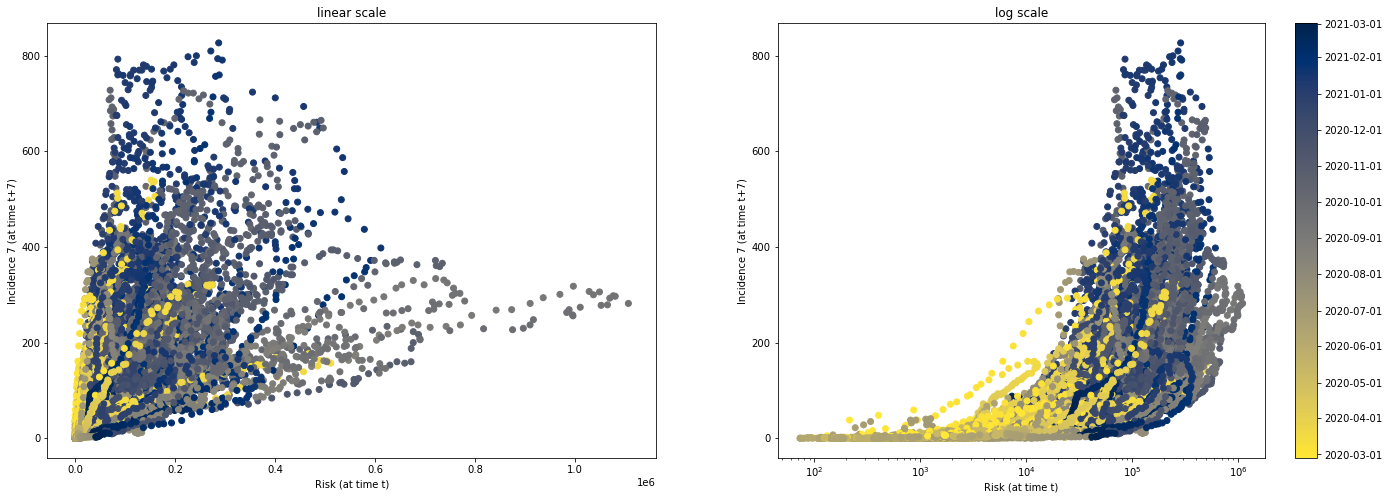

In [5]:
plot_by_date(df)

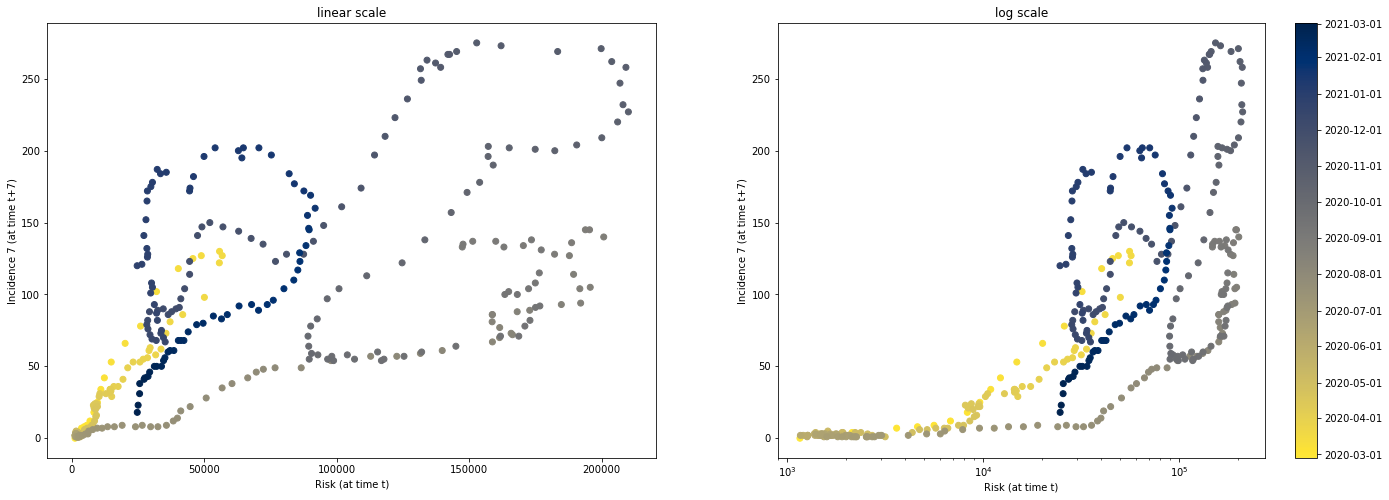

In [6]:
plot_by_date(df[df.province == 'Cantabria'])

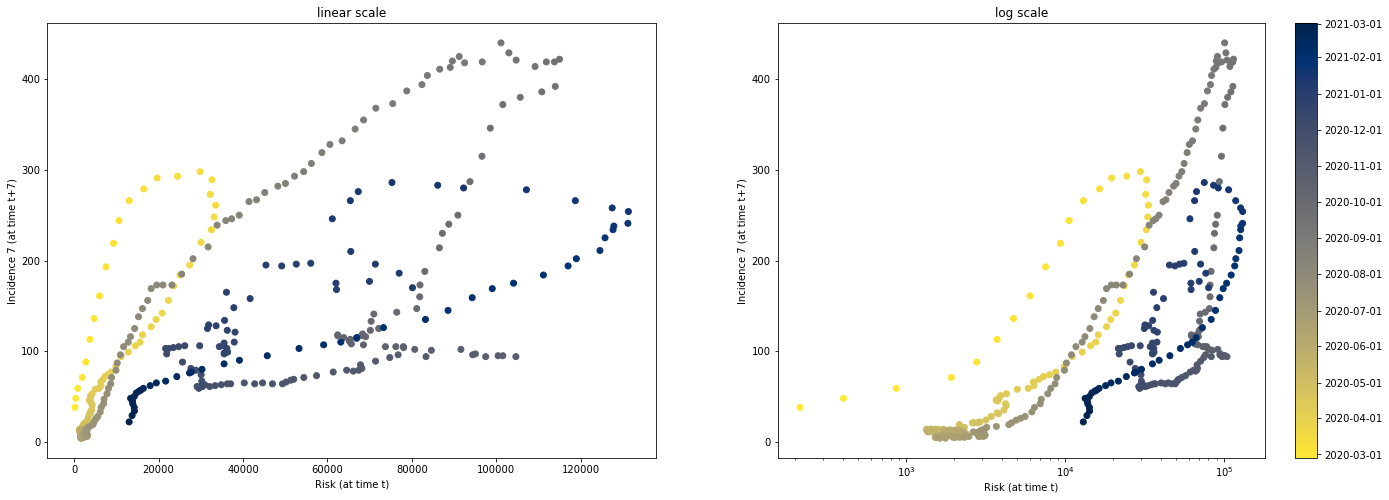

In [7]:
plot_by_date(df[df.province == 'Madrid'])

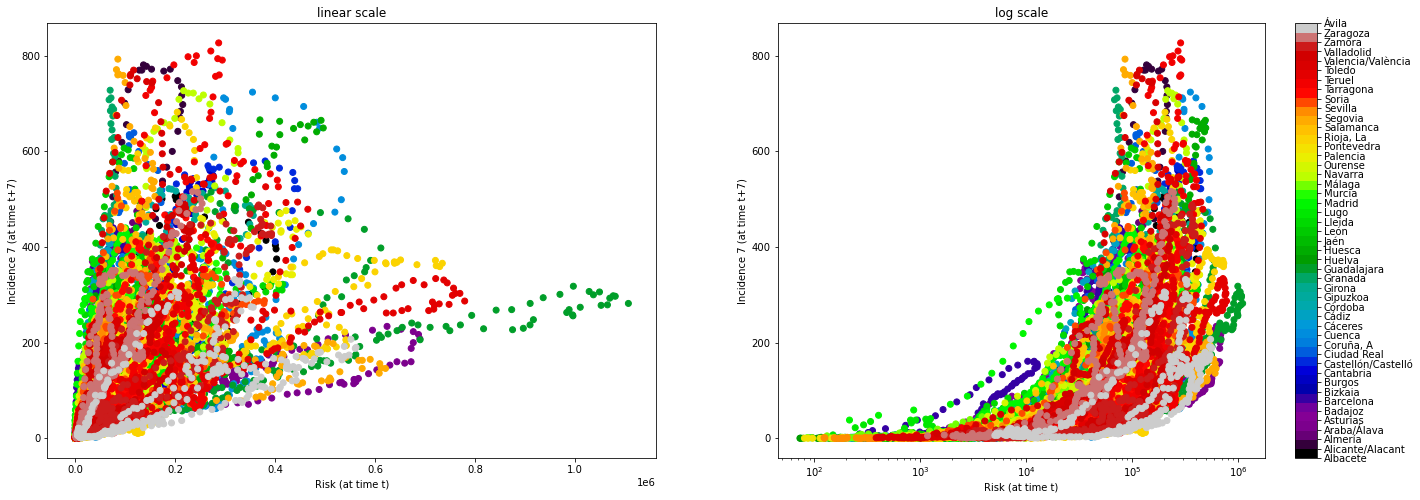

In [8]:
plot_by_province(df)

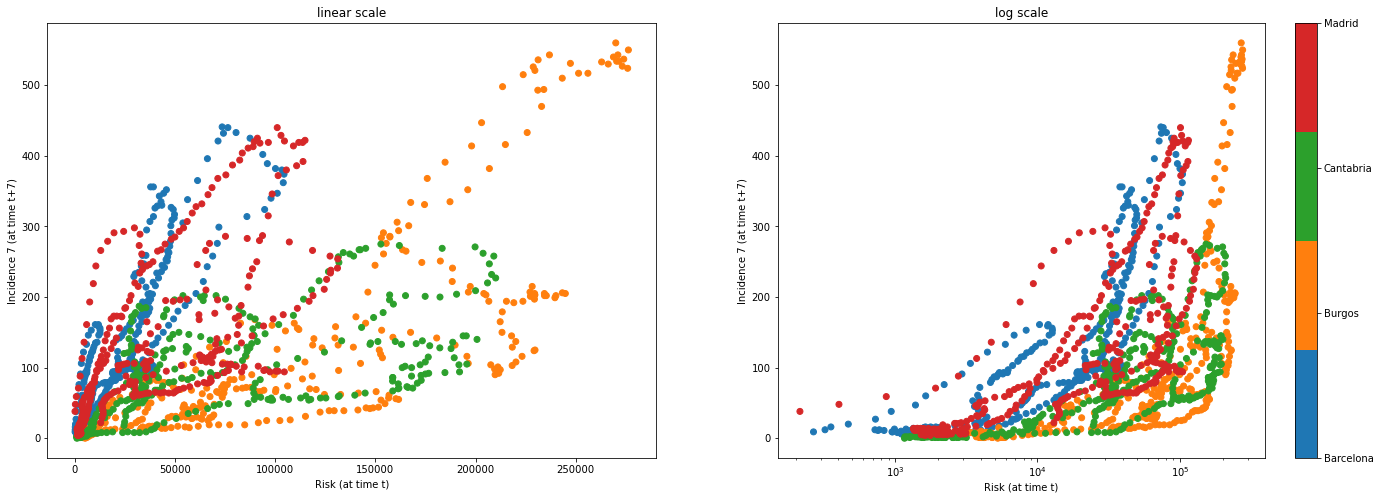

In [9]:
plot_by_province(df[df.province.isin(['Madrid', 'Cantabria', 'Burgos', 'Barcelona'])])

It looks like the relation between risk and flux could vaguely linear.

Mean absolute error in incidence: 63.04666562375725


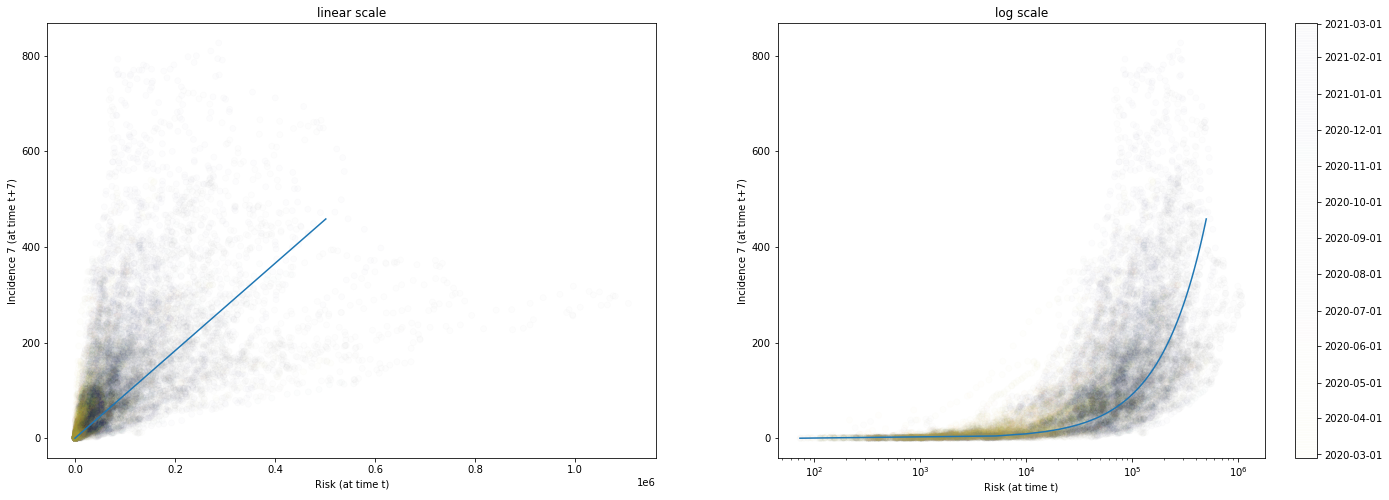

In [5]:
from scipy.optimize import curve_fit

def fit_func(x, a):
    return a * x

x = df['external risk']
y = df['incidence 7 (t+7)']

params = curve_fit(fit_func, x, y)
params = np.append(params[0], 0)
p = np.poly1d(params)

plot_by_date(df, alpha=0.01, f=p)

mae = np.abs(p(x) - y)

print(f'Mean absolute error in incidence: {mae.mean()}')

In order to have a fair comparison between models, we must fit it only to the train set.

In [8]:
def model_summary(model):
       
    print('\n# Metrics')
    metrics = {'mae': {}, 'mape': {}}
    
    for i in ['train', 'val', 'test']:
        x_t = splits[i]['X']['external risk']
        y_t = splits[i]['y'].loc[:, 'incidence 7 (t+7)']

        y_p = model(x_t)

        mae = np.abs(y_p - y_t)
        mape = np.abs( (y_p - y_t) / y_t)
        mape = mape.replace([np.inf, -np.inf], np.nan)
        
        metrics['mae'][i] = mae.mean()
        metrics['mape'][i] = mape.mean()

        print(f' - {i.capitalize()}')
        print(f'   Mean Absolute Error (in incidence): {mae.mean():.4f}')
        print(f'   Mean Absolute Percentage Error (in incidence): {mape.mean():.4f}')
        
    return metrics


def save_metrics(metrics, modelname):
    for m in metrics.keys():
        b = pd.DataFrame.from_dict(metrics[m], orient='index', columns=[modelname]).T
        a = pd.read_csv(f'single_step/{m}.csv', index_col=0)
        a = pd.concat([a[~a.index.isin(b.index)], b])
        a.to_csv(f'single_step/{m}.csv')


# Metrics
 - Train
   Mean Absolute Error (in incidence): 51.3827
   Mean Absolute Percentage Error (in incidence): 0.6417
 - Val
   Mean Absolute Error (in incidence): 134.6703
   Mean Absolute Percentage Error (in incidence): 0.6217
 - Test
   Mean Absolute Error (in incidence): 39.3340
   Mean Absolute Percentage Error (in incidence): 0.7226


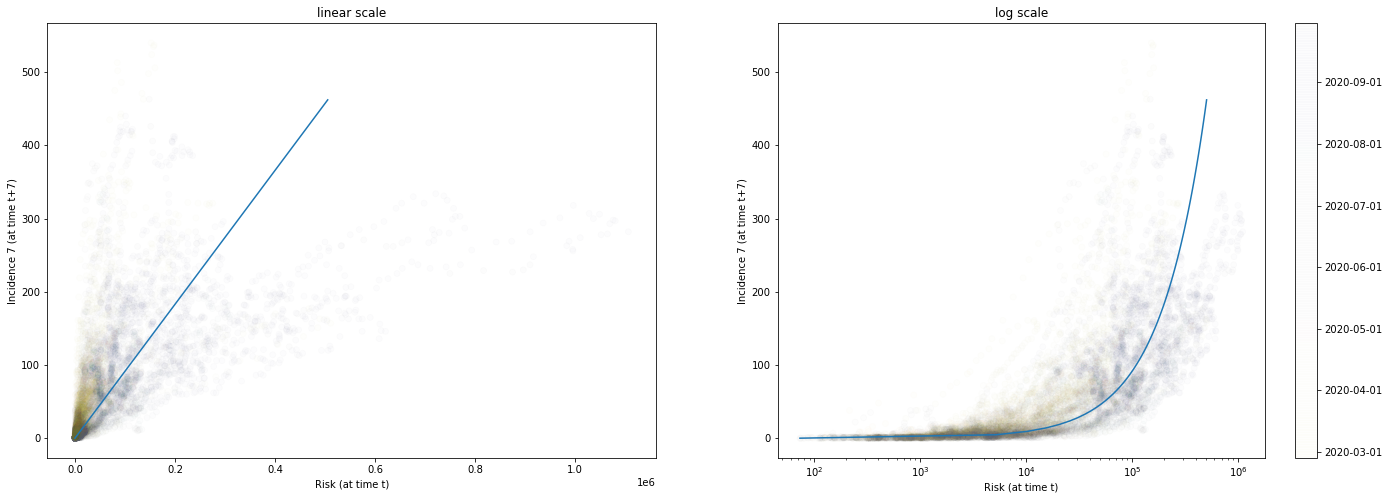

In [11]:
from scipy.optimize import curve_fit

def fit_func(x, a):
    return a * x

x = splits['train']['X']['external risk']
y = splits['train']['y'].loc[:, 'incidence 7 (t+7)']

params = curve_fit(fit_func, x, y)
params = np.append(params[0], 0)
model = np.poly1d(params)

plot_by_date(df[df['date']<'2020-10-01'],
             alpha=0.01, f=p)   

metrics = model_summary(model)
save_metrics(metrics, 'BSC')